# Problem Statement

Our client wants to try to predict COVID-19 hotspots based on demographics and has asked us to build a predictive model that could predict if a county is a COVID-19 hotspot.  Since we are cautious about trying to predict an ongoing problem with many changes in real-time data, we informed that if our models don't meet a __.95 accuracy score or better__ that they should only use the model for interpretive purposes and not predictive purposes.  While the client understands the low likelihood of building a predictive model under this criteria, they gave us the budget to proceed anyway.

We defined a "COVID-19 hotspot" as a county in the contiguous US that has a rate of infected residents per capita that is higher than one standard deviation for the mean.  This actually presents an interesting situation where we already know that our baseline model will have an accuracy rate of .7625.  Due to this, we will only consider our model interpretable if we can beat the baseline accuracy.

We are viewing this as a classification problem and will look to run Logistic Regression, KNN, Support Vector Machine, Decision Tree Classifier, Bagging Classifier,Random Forest, and AdaBoost models in order to see if it's possible to predict COVID-19 hotspots based on county demographic data.

To reiterate, our goal for the model to be considered predictive is a __.95 accuracy score or better__, and our goal for the model to be considered interpretable is a __.7626 accuracy score or better__.  This is to ensure that we are held to high standards when it comes to predicting an ongoing pandemic, but also ensures that we can interpret the findings if we are performing better than average.



# Executive Summary

# Data Collection

In [1882]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.base import TransformerMixin # from Mahdi

import regex as re

random_state = 11

Data was initially pulled on May 8

In [1883]:
master = pd.read_csv('~/downloads/new_beds.csv')

In [1884]:
master = master.drop(columns = 'Unnamed: 0')

Master was the result of all of our cleaned dataframes merged into one, however we found some more specific area data after the fact, which is why we read in a separate dataframe.  We will have to do a little more cleaning, but master will remain as our Master dataframe.

In [1885]:
area = pd.read_csv('~/downloads/area_ready.csv')


In [1886]:
area = area.drop(columns = 'Unnamed: 0')
# csv was created without index = False, so have to drop the first column
area.head()

,county,total_area,land_area,water_area
0,autauga county,1513895194,1539602155,2.570696e+07
1,baldwin county,2984648805,4117625664,1.132977e+09
2,barbour county,2241636927,2292160140,5.052321e+07
3,bibb county,1602558222,1612159622,9.601400e+06
4,blount county,1655136409,1670127873,1.499146e+07


# Additional Cleaning

Since we are still treated our master as the master, first, we're going to merge area and master and save over the master dataframe.

In [1887]:
master = pd.merge(area, master, how = 'left', on=area.index)

master.head()

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
0,0,autauga county,1513895194,1539602155,2.570696e+07,autauga county,AL,1001,55200,54170,...,0.0,0.0,0.0,0.0,1,1001,85.0,0.001214,0.001540,1.268657
1,1,baldwin county,2984648805,4117625664,1.132977e+09,baldwin county,AL,1003,208107,204535,...,0.0,0.0,0.0,0.0,1,1003,386.0,0.000999,0.001855,1.855769
2,2,barbour county,2241636927,2292160140,5.052321e+07,barbour county,AL,1005,25782,25429,...,0.0,0.0,0.0,0.0,1,1005,74.0,0.002056,0.002870,1.396226
3,3,bibb county,1602558222,1612159622,9.601400e+06,bibb county,AL,1007,22527,22340,...,0.0,0.0,0.0,0.0,1,1007,35.0,0.001953,0.001554,0.795455
4,4,blount county,1655136409,1670127873,1.499146e+07,blount county,AL,1009,57645,56710,...,0.0,0.0,0.0,0.0,1,1009,25.0,0.000763,0.000434,0.568182


Even though we've cleaned, we still want to check our null values.

In [1888]:
master.isnull().sum().sort_values()

key_0                                  0
# hosp w/diag radioisotope fac         0
other spec, tot, pc, hosp res          0
forensic path, pc, hosp ft stf         0
# stng/lt hosps,100-199 beds_y         0
                                    ... 
skilled nurs fac certified beds_x      0
# stng/lt hosps,050-099 beds_x         0
nursing home beds, st gen hosp_x       0
water_area                             1
beds_per_case                        103
Length: 853, dtype: int64

We are going to end up dropping beds per case when we set up our X & y variables because that would be technically leaking coronavirus data into our model, but for EDA purposes, it could be worth keeping around.  I'm more concerned investigating the water area null.

In [1889]:
master.loc[master['water_area'].isnull()]

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
889,889,greeley county,2016057907,2016057907,NaN,greeley county,KS,20071,1200,1179,...,0.0,0.0,0.0,0.0,20,20071,18.0,0.0,0.015,inf


Since total area for Greeley County equals land area, I'm going to impute 0 for water area in this case.

In [1890]:
master['water_area'].replace({None: 0}, inplace = True)

master['pop_density'] = master['population'] / master['total_area']

The census data we collected is in total units, but we want to see if ratios might be a better predictor of hotspots than a total.  We do want to be able to feed both into our model.  To get started, we feature engineered a column for population density.  Next we want to create a for loop to loop through the census-specific columns and create ratios with the population as a denominator for all of them.

In [1891]:
cens = master[master.columns[8:]]
cens.drop(columns = 'county_y', inplace = True)
cens.shape

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(3108, 845)

In [1892]:
cens.dtypes.value_counts()

float64    748
int64       97
dtype: int64

In [1893]:
cens.dtypes.sort_values()

population                                                   int64
estimate!!sex and age!!total population!!65 to 74 years      int64
estimate!!sex and age!!total population!!60 to 64 years      int64
estimate!!sex and age!!total population!!55 to 59 years      int64
estimate!!sex and age!!total population!!45 to 54 years      int64
                                                            ...   
dist hosp by 05 - 14 services                              float64
int med subspecs, pc, hosp res                             float64
ophthalmolgy, pc, hosp resdnts                             float64
preventable hospital stays rate                            float64
pop_density                                                float64
Length: 845, dtype: object

In [1894]:
ratios = [] # instantiate empty list
for num in range(845): #iterates through all census columns
    ratio = cens[cens.columns[num]]/ cens['population']
    ratios.append(ratio) 
    

ratio_df = pd.DataFrame(ratios).T 
#turn list into a dataframe, need to transpose, so the values and columns line up properly
ratio_df.columns =  cens.columns

ratio_df.columns = ratio_df.columns + ' ratio'

ratio_df.head()

,population ratio,estimate!!race!!total population!!one race ratio,estimate!!race!!total population!!two or more races ratio,estimate!!race!!total population!!one race.1 ratio,estimate!!race!!total population!!one race!!white ratio,estimate!!race!!total population!!one race!!black or african american ratio,estimate!!race!!total population!!one race!!american indian and alaska native ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!cherokee tribal grouping ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!chippewa tribal grouping ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!navajo tribal grouping ratio,...,nursing facilities total beds ratio,nurse practitioners_y ratio,"advpractnurs midwve,male w/npi ratio",st_num ratio,countyfips ratio,beds ratio,case_per_pop ratio,beds_per_pop ratio,beds_per_case ratio,pop_density ratio
0,1.0,0.981341,0.018659,0.981341,0.768786,0.191395,0.002880,0.001486,0.0,0.000797,...,0.0,0.0,0.0,0.000018,0.018134,0.001540,2.198855e-08,2.789593e-08,0.000023,6.605477e-10
1,1.0,0.982836,0.017164,0.982836,0.862662,0.094970,0.007314,0.001369,0.0,0.000336,...,0.0,0.0,0.0,0.000005,0.004820,0.001855,4.802750e-09,8.912795e-09,0.000009,3.350478e-10
2,1.0,0.986308,0.013692,0.986308,0.473819,0.475758,0.002793,0.001008,0.0,0.000349,...,0.0,0.0,0.0,0.000039,0.038981,0.002870,7.973384e-08,1.113265e-07,0.000054,4.461026e-10
3,1.0,0.991699,0.008301,0.991699,0.766547,0.222755,0.000355,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000044,0.044702,0.001554,8.670536e-08,6.897017e-08,0.000035,6.240023e-10
4,1.0,0.983780,0.016220,0.983780,0.955052,0.014954,0.002446,0.000347,0.0,0.000000,...,0.0,0.0,0.0,0.000017,0.017504,0.000434,1.324126e-08,7.523445e-09,0.000010,6.041798e-10


In [1895]:
# ratio_df.to_csv('~/documents/population_ratios.csv')

In [1896]:
master = master.join(ratio_df)

We overwrote the Master to include the ratio columns.  Data is cleaned up to where we want.

# EDA

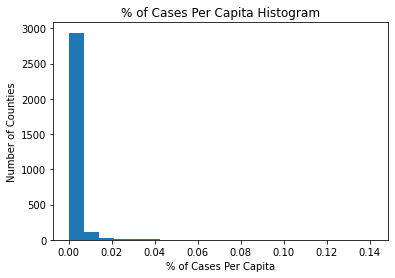

In [1897]:
plt.hist(master['case_per_pop'], bins = 20)
plt.title('% of Cases Per Capita Histogram')
plt.xlabel('% of Cases Per Capita')
plt.ylabel('Number of Counties');

In [1898]:
# After everything is grouped, I can run some boxplots, diplaying differences between hotspots and non-hotspots.
# I can also look at relationships, like cases per pop vs beds per pop.

In [1899]:
.95/2/2

0.2375

In [1900]:
master.shape[0] * 0.2375

738.15

In [1901]:
master.shape[0] - 739

2369

This informs us on how many counties will be designated as a "hotspot."  I'm going to round up for the cutoff because the value should be larger than 738, and since you can't have .15 of a county, I will use 739 as designated hotspots.  That leaves us with 2369 that will not be considered hotspots.

In [1902]:
above_std_1 = master.sort_values(by = 'case_per_pop', ascending = False).head(739)

This creates a list of counties that meet our criteria of a COVID-19 hotspot.

In [1903]:
above_std_1['case_per_pop'].sort_values().head(1)

2    0.002056
Name: case_per_pop, dtype: float64

This shows our cutoff point for our cases per population ratio.

In [1904]:
below = master.sort_values(by = 'case_per_pop', ascending = False).tail(2369)

In [1905]:
above_std_1['case_per_pop'] = ((above_std_1['case_per_pop'].values *0) +1).astype(int)

below['case_per_pop'] = ((below['case_per_pop'].values *0)).astype(int)

master['case_per_pop'] = pd.concat([above_std_1['case_per_pop'],below['case_per_pop']])
master.head()

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,nursing facilities total beds ratio,nurse practitioners_y ratio,"advpractnurs midwve,male w/npi ratio",st_num ratio,countyfips ratio,beds ratio,case_per_pop ratio,beds_per_pop ratio,beds_per_case ratio,pop_density ratio
0,0,autauga county,1513895194,1539602155,2.570696e+07,autauga county,AL,1001,55200,54170,...,0.0,0.0,0.0,0.000018,0.018134,0.001540,2.198855e-08,2.789593e-08,0.000023,6.605477e-10
1,1,baldwin county,2984648805,4117625664,1.132977e+09,baldwin county,AL,1003,208107,204535,...,0.0,0.0,0.0,0.000005,0.004820,0.001855,4.802750e-09,8.912795e-09,0.000009,3.350478e-10
2,2,barbour county,2241636927,2292160140,5.052321e+07,barbour county,AL,1005,25782,25429,...,0.0,0.0,0.0,0.000039,0.038981,0.002870,7.973384e-08,1.113265e-07,0.000054,4.461026e-10
3,3,bibb county,1602558222,1612159622,9.601400e+06,bibb county,AL,1007,22527,22340,...,0.0,0.0,0.0,0.000044,0.044702,0.001554,8.670536e-08,6.897017e-08,0.000035,6.240023e-10
4,4,blount county,1655136409,1670127873,1.499146e+07,blount county,AL,1009,57645,56710,...,0.0,0.0,0.0,0.000017,0.017504,0.000434,1.324126e-08,7.523445e-09,0.000010,6.041798e-10


This takes our newly created 1 and 0 classifiers for our counties.

In [1906]:
# master.to_csv('~/documents/case_per_pop_dummied_std_1.csv')

# Model Preparation

In [1907]:
master['case_per_pop'].value_counts(normalize = True)

0    0.762227
1    0.237773
Name: case_per_pop, dtype: float64

Since we are using accuracy as our metric, our baseline is a score of .76227, which would occur if our model predicted an area to not be a coronavirus hotspot.

In [1908]:
master.isnull().sum().sort_values()

key_0                                      0
# stng/lt hosps,006-049 beds_x ratio       0
neonatal intens cr, beds set up ratio      0
total inpatient, beds set up_y ratio       0
# stng/lt hosps,050-099 beds_x ratio       0
                                        ... 
nuclear med, pc, hosp ft staff             0
# hosp w/c.t. scanner                      0
# hosp w/other long-term care              0
beds_per_case                            103
beds_per_case ratio                      103
Length: 1699, dtype: int64

In [1909]:
X = master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 
                           'case_per_pop', 'beds_per_case', 'beds_per_case ratio', 'unnamed: 0_y', 'st_num',
                           'cases', 'countyfips', 'key_0', 'county', 'case_per_pop ratio',
                           'population ratio', 'st_num ratio', 'cases ratio', 'total_covid ratio',
                           'deaths ratio', 'countyfips ratio'])
y = master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [1910]:
pipe = Pipeline([ #instantiate transformers and model
    ('lr', LogisticRegression(random_state = 11))
])

# set hyperparameters

pipe_params = {'lr__dual' : [True, False],
               'lr__class_weight' : ['dict', 'balanced', None],
              'lr__solver': ['liblinear', 'lbfgs', None],
              'lr__penalty': ['l1'] # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [1911]:
logreg_model = gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit fail

[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=None, tota

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'd

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=Fal

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)



[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/pyt

[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.8s
[CV] lr__class_wei

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError:

[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dua

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)



[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.4s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   2.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   2.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.9s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   19.8s finished


In [1912]:
logreg_train_score = logreg_model.score(X_train, y_train)

In [1913]:
logreg_test_score = logreg_model.score(X_test, y_test)

In [1914]:
logreg_model.best_params_

{'lr__class_weight': None,
 'lr__dual': False,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear'}

In [1915]:
cross_val_score(logreg_model.best_estimator_, X_ss, y).mean()

0.7770425255396596

In [1916]:
coefs = logreg_model.best_estimator_.steps[0][1].coef_

coef_df = pd.DataFrame(coefs).T

coef_df['coefficients'] = list(X.columns)

coef_df.rename(columns=({0: 'coefficient',
                        'coefficients': 'feature'}), inplace=True)

coef_df.sort_values(by = 'coefficient')

,coefficient,feature
75,-2.393127,estimate!!sex and age!!total population!!75 to...
893,-1.402154,"estimate!!citizen, voting age population!!citi..."
927,-1.005262,unnamed: 0_y ratio
878,-0.862214,estimate!!hispanic or latino and race!!total p...
20,-0.808956,estimate!!race!!total population!!one race!!as...
...,...,...
915,0.887311,estimate!!sex and age!!total population!!16 ye...
47,1.005249,estimate!!hispanic or latino and race!!total p...
19,1.237792,estimate!!race!!total population!!one race!!as...
923,1.404032,estimate!!sex and age!!total population!!18 ye...


In [1917]:
logreg_model.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=11,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [1918]:
logreg_train_score

0.8266838266838267

In [1919]:
logreg_test_score

0.8056628056628057

In [1920]:
coef_df['abs'] = abs(coef_df['coefficient'])

In [1921]:
lose_these = coef_df.loc[coef_df['abs'] < 0.0000001]

In [1922]:
# lose_these.to_csv('~/documents/bad_features.csv')

In [1923]:
list(lose_these['feature'].values)

['total_area',
 'land_area',
 'population',
 'estimate!!race!!total population!!one race',
 'estimate!!race!!total population!!two or more races',
 'estimate!!race!!total population!!one race.1',
 'estimate!!race!!total population!!one race!!white',
 'estimate!!race!!total population!!one race!!black or african american',
 'estimate!!race!!total population!!one race!!american indian and alaska native!!navajo tribal grouping',
 'estimate!!race!!total population!!one race!!american indian and alaska native!!sioux tribal grouping',
 'estimate!!race!!total population!!one race!!asian',
 'estimate!!race!!total population!!one race!!asian!!chinese',
 'estimate!!race!!total population!!one race!!asian!!other asian',
 'estimate!!race!!total population!!one race!!native hawaiian and other pacific islander',
 'estimate!!race!!total population!!one race!!native hawaiian and other pacific islander!!native hawaiian',
 'estimate!!race!!total population!!one race!!some other race',
 'estimate!!race!!

In [1924]:
better_master = master.drop(columns = list(lose_these['feature'].values))

In [1925]:
better_master.shape

(3108, 131)

In [1926]:
X = better_master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 
                           'case_per_pop', 'beds_per_case', 'beds_per_case ratio', 'unnamed: 0_y', 'st_num',
                           'cases', 'countyfips', 'key_0', 'county', 'case_per_pop ratio',
                           'population ratio', 'st_num ratio', 'cases ratio', 'total_covid ratio',
                           'deaths ratio', 'countyfips ratio'])
y = better_master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [1927]:
pipe = Pipeline([ #instantiate transformers and model
    ('lr', LogisticRegression(random_state = 11))
])

# set hyperparameters

pipe_params = {'lr__dual' : [True, False],
               'lr__class_weight' : ['dict', 'balanced', None],
              'lr__solver': ['liblinear', 'lbfgs', None],
              'lr__penalty': ['l1', 'l2', 'none'] # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [1928]:
logreg_2 = gs.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalt

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit fail


[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__du

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'd

[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'd


[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__p

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in [


[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__pen

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balance

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/e

[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_wei

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/e

[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_w

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 270 out of 270 | elap

In [1929]:
logreg_2_train_score = logreg_2.score(X_train, y_train)

In [1930]:
logreg_2_test_score = logreg_2.score(X_test, y_test)

In [1931]:
logreg_2.best_params_

{'lr__class_weight': 'dict',
 'lr__dual': False,
 'lr__penalty': 'none',
 'lr__solver': 'lbfgs'}

In [1932]:
cross_val_score(logreg_2.best_estimator_, X_ss, y).mean()

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

0.7863719444314998

In [1933]:
new_coefs = logreg_2.best_estimator_.steps[0][1].coef_

In [1934]:
new_coef_df = pd.DataFrame(new_coefs).T

In [1935]:
new_coef_df

,0
0,-0.006155
1,0.714659
2,-0.168225
3,0.219950
4,-0.434883
...,...
104,-0.324234
105,-0.099186
106,0.047428
107,0.040452


In [1936]:
len(X.columns)

109

In [1937]:
new_coef_df['coefficients'] = list(X.columns)

In [1938]:
new_coef_df.rename(columns=({0: 'coefficient',
                        'coefficients': 'feature'}), inplace=True)

In [1939]:
new_coef_df.sort_values(by = 'coefficient')

,coefficient,feature
23,-5.330073,estimate!!sex and age!!total population!!75 to...
78,-3.402592,estimate!!sex and age!!total population!!sex r...
14,-1.952018,estimate!!race!!total population!!two or more ...
8,-1.629154,estimate!!race!!total population!!one race!!as...
45,-1.465498,estimate!!race!!total population!!one race!!am...
...,...,...
6,1.490142,estimate!!race!!total population!!one race!!as...
22,2.385746,estimate!!sex and age!!total population!!60 to...
7,2.562487,estimate!!race!!total population!!one race!!as...
95,2.976099,estimate!!sex and age!!total population!!18 ye...


In [1940]:
new_coef_df[abs(new_coef_df['coefficient']) > .0000001]

,coefficient,feature
0,-0.006155,water_area
1,0.714659,estimate!!race!!total population!!one race!!am...
2,-0.168225,estimate!!race!!total population!!one race!!am...
3,0.219950,estimate!!race!!total population!!one race!!am...
4,-0.434883,estimate!!race!!total population!!one race!!as...
...,...,...
104,-0.324234,"medical specs, total, 45-54 ratio"
105,-0.099186,"physician assistants, prim care ratio"
106,0.047428,"child psychiatry, < 35 ratio"
107,0.040452,beds ratio


In [1941]:
logreg_2.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=1.0, class_weight='dict', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='none', random_state=11,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [1942]:
print(f' Training Score: {logreg_2_train_score}')
print(f' Testing Score: {logreg_2_test_score}')



 Training Score: 0.8352638352638353
 Testing Score: 0.8120978120978121


# KNN Model

In [1943]:
pipe = Pipeline([
    ('knn', KNeighborsClassifier())])

# set hyperparameters

pipe_params = {
    'knn__n_neighbors': [3,5,7,9,27],
    'knn__weights' : ['uniform', 'distance'], # distance gives more predictive power to closer neighbors
    'knn__p': [1,2,'p'], # allows us to test Minkowski, Euclidean, and Manhattan measurements
               
              }

gsknn = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2
                    )

In [1944]:
knn_model = gsknn.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.7s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance ..........

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance ...........

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.9s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=distance ...........

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   1.0s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance ...........

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=uniform .............
[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=uniform .............
[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=uniform .............
[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=uniform .............
[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=uniform, total=   0.9s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=distance ............
[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=distance ............
[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=distance, total=   0.6s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=distance ...

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

In [1945]:
knn_model.score(X_test, y_test)

0.8043758043758044

In [1946]:
knn_model.score(X_train, y_train)

1.0

In [1947]:
knn_model.best_params_

{'knn__n_neighbors': 27, 'knn__p': 2, 'knn__weights': 'distance'}

In [1948]:
cross_val_score(knn_model.best_estimator_, X_ss, y).mean()

0.7940832906162139

# SVM

In [1949]:
pipe = Pipeline([ #instantiate
    ('svc', SVC())])

# set hyperparameters

pipe_params = {
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__class_weight' : [dict, 'balanced'],
    'svc__random_state': [11],
    'svc__gamma' : ['scale', 'auto'],
    'svc__C' : [0, .5, 1],
    'svc__shrinking' : [True, False]
              }

gssvc = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [1950]:
svc_model = gssvc.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these

[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'd

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>,

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarni

[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc_

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarni

[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__rand

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarni

[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__ran

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p


[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc__cl

[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.2s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   2.4s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   2.5s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.9s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=sc

[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   2.1s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.9s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.3s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.2s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=1, svc__class_weight=<class 'd

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.8s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.7s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.9s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.7s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel

[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.5s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.3s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   1.8s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   5.0s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linea

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.9min finished


In [1951]:
svc_model.score(X_test, y_test)

0.8043758043758044

In [1952]:
svc_model.score(X_train, y_train)

0.8416988416988417

In [1953]:
svc_model.best_params_

{'svc__C': 1,
 'svc__class_weight': 'balanced',
 'svc__gamma': 'scale',
 'svc__kernel': 'poly',
 'svc__random_state': 11,
 'svc__shrinking': True}

In [1954]:
new_coef_df.sort_values(by = 'coefficient')

,coefficient,feature
23,-5.330073,estimate!!sex and age!!total population!!75 to...
78,-3.402592,estimate!!sex and age!!total population!!sex r...
14,-1.952018,estimate!!race!!total population!!two or more ...
8,-1.629154,estimate!!race!!total population!!one race!!as...
45,-1.465498,estimate!!race!!total population!!one race!!am...
...,...,...
6,1.490142,estimate!!race!!total population!!one race!!as...
22,2.385746,estimate!!sex and age!!total population!!60 to...
7,2.562487,estimate!!race!!total population!!one race!!as...
95,2.976099,estimate!!sex and age!!total population!!18 ye...


In [1955]:
coef_df['actual_odds'] = np.exp(coef_df['coefficient'])

In [1956]:
new_coef_df['actual_odds'] = np.exp(new_coef_df['coefficient'])

In [1957]:
coef_df

,coefficient,feature,abs,actual_odds
0,0.000000,total_area,0.000000,1.000000
1,0.000000,land_area,0.000000,1.000000
2,-0.006639,water_area,0.006639,0.993383
3,0.000000,population,0.000000,1.000000
4,0.000000,estimate!!race!!total population!!one race,0.000000,1.000000
...,...,...,...,...
1672,0.000000,nurse practitioners_y ratio,0.000000,1.000000
1673,0.000000,"advpractnurs midwve,male w/npi ratio",0.000000,1.000000
1674,0.022756,beds ratio,0.022756,1.023017
1675,-0.182812,beds_per_pop ratio,0.182812,0.832925


In [1958]:
new_coef_df

,coefficient,feature,actual_odds
0,-0.006155,water_area,0.993864
1,0.714659,estimate!!race!!total population!!one race!!am...,2.043490
2,-0.168225,estimate!!race!!total population!!one race!!am...,0.845163
3,0.219950,estimate!!race!!total population!!one race!!am...,1.246014
4,-0.434883,estimate!!race!!total population!!one race!!as...,0.647341
...,...,...,...
104,-0.324234,"medical specs, total, 45-54 ratio",0.723081
105,-0.099186,"physician assistants, prim care ratio",0.905574
106,0.047428,"child psychiatry, < 35 ratio",1.048570
107,0.040452,beds ratio,1.041281


In [1959]:
lasso_eval = coef_df.loc[coef_df['coefficient'] != 0].sort_values(by = 'coefficient')

In [1960]:
#lasso_eval.to_csv('~/documents/lasso_coef.csv')

In [1961]:
logreg2_eval = new_coef_df.loc[new_coef_df['coefficient'] != 0].sort_values(by = 'coefficient')

In [1962]:
#logreg2_eval.to_csv('~/documents/logreg_coefs.csv')

In [1963]:
# master.to_csv('~/documents/master_w_ratios.csv')

In [1964]:
# better_master.to_csv('~/documents/lassoed_df.csv')

In [1965]:
better_master

,key_0,county,water_area,county_x,state,id,estimate!!race!!total population!!one race!!american indian and alaska native,estimate!!race!!total population!!one race!!american indian and alaska native!!cherokee tribal grouping,estimate!!race!!total population!!one race!!american indian and alaska native!!chippewa tribal grouping,estimate!!race!!total population!!one race!!asian!!asian indian,...,"occupat med, total ratio","medical specs, total, 45-54 ratio","physician assistants, prim care ratio","child psychiatry, < 35 ratio",st_num ratio,countyfips ratio,beds ratio,case_per_pop ratio,beds_per_pop ratio,beds_per_case ratio
0,0,autauga county,2.570696e+07,autauga county,AL,1001,159,82,0,0,...,0.0,0.0,0.0,0.0,0.000018,0.018134,0.001540,2.198855e-08,2.789593e-08,0.000023
1,1,baldwin county,1.132977e+09,baldwin county,AL,1003,1522,285,0,43,...,0.0,0.0,0.0,0.0,0.000005,0.004820,0.001855,4.802750e-09,8.912795e-09,0.000009
2,2,barbour county,5.052321e+07,barbour county,AL,1005,72,26,0,11,...,0.0,0.0,0.0,0.0,0.000039,0.038981,0.002870,7.973384e-08,1.113265e-07,0.000054
3,3,bibb county,9.601400e+06,bibb county,AL,1007,8,0,0,37,...,0.0,0.0,0.0,0.0,0.000044,0.044702,0.001554,8.670536e-08,6.897017e-08,0.000035
4,4,blount county,1.499146e+07,blount county,AL,1009,141,20,0,42,...,0.0,0.0,0.0,0.0,0.000017,0.017504,0.000434,1.324126e-08,7.523445e-09,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,3103,sweetwater county,1.662303e+08,sweetwater county,WY,56037,742,0,0,0,...,0.0,0.0,0.0,0.0,0.001269,1.270191,0.002607,6.165514e-09,5.908618e-08,0.000217
3104,3104,teton county,5.708591e+08,teton county,WY,56039,77,30,0,6,...,0.0,0.0,0.0,0.0,0.002429,2.430244,0.002082,1.260068e-07,9.027350e-08,0.000031
3105,3105,uinta county,1.662582e+07,uinta county,WY,56041,160,0,0,0,...,0.0,0.0,0.0,0.0,0.002717,2.719249,0.010918,1.648102e-08,5.297472e-07,0.001560
3106,3106,washakie county,1.042960e+07,washakie county,WY,56043,52,42,0,0,...,0.0,0.0,0.0,0.0,0.006889,6.894206,0.002214,7.566513e-08,2.723945e-07,0.000443


In [1966]:
new_coef_df.shape

(109, 3)

In [1985]:
new_coef_df.to_csv('~/documents/fin_coefficients.csv')

# Decision Tree Classifier

In [1968]:
dt_pipe = Pipeline([
    ('dt' ,DecisionTreeClassifier())
])
pipe_params = {
    'dt__max_depth' : [10],
    'dt__min_samples_leaf' : [8],
    'dt__min_samples_split' : [3],
    }
gs = GridSearchCV(dt_pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=StratifiedKFold(shuffle=True)
                  ,
                  verbose = 2) # 3-fold cross-validation.
gs.fit(X_train,y_train)
gs.best_params_
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Train Score 0.8978978978978979
Test Score 0.7593307593307593
Cross Val Score 0.7500064722908285


# Bagging Classifier

In [1969]:
bag_pipe = Pipeline([
    ('bag', BaggingClassifier())])
pipe_params = {
    'bag__n_estimators': [50],
    'bag__max_features': [.9]
    }
gs = GridSearchCV(bag_pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=StratifiedKFold(shuffle=True),
                  verbose = 2) # 3-fold cross-validation.
gs.fit(X_train,y_train)
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished


Train Score 1.0
Test Score 0.8198198198198198
Cross Val Score 0.7882996515318619


# Random Forest Classifier

In [1970]:
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())])
rf_params = {
    'rf__max_depth':[5,10],
    'rf__n_estimators':[20,25,30]
}
gs = GridSearchCV(rf_pipe, param_grid=rf_params, cv=5,verbose=50)
gs.fit(X_train, y_train)
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] rf__max_depth=5, rf__n_estimators=20 ............................
[CV]  rf__max_depth=5, rf__n_estimators=20, score=0.816, total=   0.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[CV] rf__max_depth=5, rf__n_estimators=20 ............................
[CV]  rf__max_depth=5, rf__n_estimators=20, score=0.822, total=   0.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[CV] rf__max_depth=5, rf__n_estimators=20 ............................
[CV]  rf__max_depth=5, rf__n_estimators=20, score=0.800, total=   0.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[CV] rf__max_depth=5, rf__n_estimators=20 ............................
[CV]  rf__max_depth=5, rf__n_estimators=20, score=0.792, total=   0.2s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

# Adaboost

In [1971]:
ada_pipe = Pipeline([
    ('ada', AdaBoostClassifier())])
ada_params = {
    'ada__n_estimators' : [250],
    'ada__learning_rate' : [1.5]
    }
gs = GridSearchCV(ada_pipe, param_grid=ada_params, cv=StratifiedKFold(shuffle=True),verbose=12, n_jobs=-1)
gs.fit(X_train, y_train)
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.7s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.7s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


Train Score 0.9253539253539254
Test Score 0.7722007722007722
Cross Val Score 0.7059555431287571


# Model Evaluation

In [1973]:
X = master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 
                           'case_per_pop', 'beds_per_case', 'beds_per_case ratio', 'unnamed: 0_y', 'st_num',
                           'cases', 'countyfips', 'key_0', 'county', 'case_per_pop ratio',
                           'population ratio', 'st_num ratio', 'cases ratio', 'total_covid ratio',
                           'deaths ratio', 'countyfips ratio'])
y = master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [1974]:
logreg_preds = logreg_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, logreg_preds).ravel() # From Danielle Medellin's confusion matrix setup
cm = confusion_matrix(y_test, logreg_preds)

In [1975]:
cm

array([[553,  39],
       [112,  73]])

In [1976]:
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Non-Hotspot Prediction', 'Hotspot Prediction']

cm_df.index = ['Actual Non-Hotspot', "Actual Hotspot"]
#This adds the appropriate row and column names for the confusion matrix

cm_df

,Non-Hotspot Prediction,Hotspot Prediction
Actual Non-Hotspot,553,39
Actual Hotspot,112,73


In [1977]:
(73 + 553)/(626 + 112 +39)

0.8056628056628057

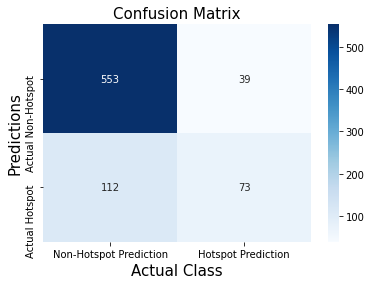

In [1978]:
sns.heatmap(cm_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Confusion Matrix', size = 15)
plt.ylabel('Predictions', size = 15)
plt.xlabel('Actual Class', size = 15);

In [1979]:
accuracy = (tp + tn)/(tp+fn+fp+tn)
print(f'Accuracy Rate: {accuracy}')

sensitivity = tp/(tp+fn)
print(f'Sensitivity Rate: {sensitivity}')
            
specificity = tn/(tn+fp)
print(f'Specificity Rate: {specificity}')

precision = tp/(tp+fp)
print(f'Precision Rate: {precision}')

true_neg = tn/(tn+fn)
print(f'True Negative Rate: {true_neg}')

Accuracy Rate: 0.8056628056628057
Sensitivity Rate: 0.3945945945945946
Specificity Rate: 0.9341216216216216
Precision Rate: 0.6517857142857143
True Negative Rate: 0.8315789473684211


In [1980]:
coef_df

,coefficient,feature,abs,actual_odds
0,0.000000,total_area,0.000000,1.000000
1,0.000000,land_area,0.000000,1.000000
2,-0.006639,water_area,0.006639,0.993383
3,0.000000,population,0.000000,1.000000
4,0.000000,estimate!!race!!total population!!one race,0.000000,1.000000
...,...,...,...,...
1672,0.000000,nurse practitioners_y ratio,0.000000,1.000000
1673,0.000000,"advpractnurs midwve,male w/npi ratio",0.000000,1.000000
1674,0.022756,beds ratio,0.022756,1.023017
1675,-0.182812,beds_per_pop ratio,0.182812,0.832925


In [1981]:
fp_counties = y_test.loc[(y_test != 1) & (logreg_preds == 1)].index #shows me misclassified rows



In [1982]:
fp_df = master.loc[master.index[fp_counties]]

In [1983]:
fp_df.sort_values(by = 'population', ascending = False)

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,nursing facilities total beds ratio,nurse practitioners_y ratio,"advpractnurs midwve,male w/npi ratio",st_num ratio,countyfips ratio,beds ratio,case_per_pop ratio,beds_per_pop ratio,beds_per_case ratio,pop_density ratio
149,149,maricopa county,23766342548,23829656320,6.331377e+07,maricopa county,AZ,4013,4253913,4099917,...,0.000000,0.0,0.000000e+00,9.403107e-07,0.000943,0.002714,3.053199e-10,6.379389e-10,4.911741e-07,4.207631e-11
338,338,orange county,2073171585,2335738262,2.625667e+08,orange county,FL,12095,1321194,1276729,...,0.000000,0.0,0.000000e+00,9.082693e-06,0.009155,0.002405,8.467228e-10,1.820053e-09,1.626957e-06,4.823527e-10
2549,2549,denton county,2085807196,2275298676,1.894915e+08,denton county,TX,48121,807047,778441,...,0.000000,0.0,0.000000e+00,5.947609e-05,0.059626,0.001839,1.338810e-09,2.278433e-09,2.108718e-06,4.794307e-10
1897,1897,bernalillo county,1857553267,1874472931,1.691966e+07,bernalillo county,NM,35001,677692,649178,...,0.000000,0.0,0.000000e+00,5.164588e-05,0.051647,0.002923,2.242707e-09,4.313400e-09,2.838016e-06,5.383426e-10
354,354,volusia county,1994708722,2852352391,8.576437e+08,volusia county,FL,12127,527634,517240,...,0.000000,0.0,0.000000e+00,2.274304e-05,0.022984,0.002754,1.928896e-09,5.219153e-09,5.128124e-06,5.013263e-10
347,347,seminole county,2078809884,2622105608,5.432957e+08,seminole county,FL,12117,455086,440178,...,0.000000,0.0,0.000000e+00,2.636864e-05,0.026626,0.000758,1.979689e-09,1.665836e-09,1.849021e-06,4.810445e-10
2291,2291,charleston county,1237819592,2377478103,1.139659e+09,charleston county,SC,45019,394708,386707,...,0.000000,0.0,0.000000e+00,1.140083e-04,0.114056,0.005396,3.087402e-09,1.367186e-08,1.121911e-05,8.078722e-10
126,126,pulaski county,1838109640,1964339775,1.262301e+08,pulaski county,AR,5119,393463,382492,...,0.000000,0.0,0.000000e+00,1.270768e-05,0.013010,0.010990,3.895018e-09,2.793045e-08,1.822487e-05,5.440372e-10
339,339,osceola county,2976496907,3438557597,4.620607e+08,osceola county,FL,12097,338619,325112,...,0.000000,0.0,0.000000e+00,3.543806e-05,0.035725,0.001855,4.831557e-09,5.476928e-09,3.347639e-06,3.359654e-10
2055,2055,lorain county,152700424,1272195481,1.119495e+09,lorain county,OH,39093,306713,295480,...,0.000000,0.0,0.000000e+00,1.271547e-04,0.127458,0.002892,5.708341e-09,9.428861e-09,5.385390e-06,6.548770e-09


In [1990]:
# fp_df.to_csv('~/documents/false_positives.csv')